In [1]:
import pandas as pd
ids = pd.read_csv("modified.csv")

res_id = []
for i in ids["Restaurant_id"]:
    res_id.append(i)

users = []
for i in ids["User_id"]:
    users.append(i)

In [2]:
data = pd.read_csv("Ds_d2.csv", usecols = ["Users", "Restaurant", "Ratings"])
data.head()
data["restaurant_id"] = res_id
data["user_id"] = users

In [3]:
ids.head()

,User_id,Restaurant_id,Rating_id
0,10,26,0
1,19,24,0
2,63,24,0
3,4,24,1
4,3,26,2


In [4]:
data.head() 

,Users,Restaurant,Ratings,restaurant_id,user_id
0,Aradhya,Subway,0.0,26,10
1,Derek,Ravens Bar & Grill,0.0,24,19
2,Rani,Ravens Bar & Grill,0.0,24,63
3,Addison,Ravens Bar & Grill,0.5,24,4
4,Adam,Subway,1.0,26,3


In [10]:
import surprise
from surprise import Dataset, Reader
from surprise.similarities import pearson, pearson_baseline
from surprise.prediction_algorithms.knns import KNNBaseline
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate
from surprise import accuracy
import numpy as np

ModuleNotFoundError: No module named 'surprise'

In [11]:
!pip install surprise

  Using cached surprise-0.1-py2.py3-none-any.whl (1.8 kB)
  Using cached scikit-surprise-1.1.1.tar.gz (11.8 MB)
  Running setup.py clean for scikit-surprise
Failed to build scikit-surprise
    Running setup.py install for scikit-surprise: started
    Running setup.py install for scikit-surprise: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'c:\users\lenovo\anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Lenovo\\AppData\\Local\\Temp\\pip-install-f_btop3t\\scikit-surprise\\setup.py'"'"'; __file__='"'"'C:\\Users\\Lenovo\\AppData\\Local\\Temp\\pip-install-f_btop3t\\scikit-surprise\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\Lenovo\AppData\Local\Temp\pip-wheel-hf2qopa5'
       cwd: C:\Users\Lenovo\AppData\Local\Temp\pip-install-f_btop3t\scikit-surprise\
  Complete output (49 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.8
  creating build\lib.win-amd64-3.8\surprise
  copying surprise\accuracy.py -> build\lib.win-amd64-3.8\surprise
  copying surprise\builtin_datasets.py -> build\lib.win-amd64-3.8\surp

In [6]:
reader = Reader(line_format='user item rating', sep=',', rating_scale = (1,10))
tot_data = Dataset.load_from_df(data[["user_id", "restaurant_id", "Ratings"]], reader=reader)

In [7]:
trainset, testset = train_test_split(tot_data, test_size=0.2)

In [8]:
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

Number of users:  89 

Number of items:  35 



In [9]:
trainset_iids = list(trainset.all_items())
iid_converter = lambda x: trainset.to_raw_iid(x)
trainset_raw_iids = list(map(iid_converter, trainset_iids))

In [10]:
trainsetfull = tot_data.build_full_trainset()
print('Number of users: ', trainsetfull.n_users, '\n')
print('Number of items: ', trainsetfull.n_items, '\n')

Number of users:  89 

Number of items:  35 



In [11]:
trainsetfull_iids = list(trainsetfull.all_items())
iid_converter = lambda x: trainsetfull.to_raw_iid(x)
trainsetfull_raw_iids = list(map(iid_converter, trainsetfull_iids))

In [12]:
sim_options = {"name":"pearson", "user_based":False}

In [13]:
def return_top_similar_dataframe(similarity_matrix, raw_ids, top_x):
    length = similarity_matrix.shape[0]
    closest_ids = np.zeros((top_x,length))
    for item in range(0,length):    
        similarity_metrics = similarity_matrix[item]        
        sorted_metrics, sorted_raw_ids = zip(*sorted(zip(similarity_metrics, raw_ids)))        
        for index in range(0, top_x):
            closest_ids[index][item] = sorted_raw_ids[-2-index]
        similarity_df = pd.DataFrame()
        similarity_df['restaurant_id'] = raw_ids
        for index in range(0, top_x): 
            similarity_df['similar_res_' + str(index + 1)] = closest_ids[index].astype(int)
    return similarity_df

In [14]:
id_to_name_dict = {}
res_names = data["Restaurant"]
res_ids = data["restaurant_id"]
for index in range(0, len(res_ids)):
    id_to_name_dict[str(res_ids[index])] = res_names[index]

def get_res_name_from_id(res_id):
    return id_to_name_dict[str(res_id)]

In [15]:
def save_similar_res(similarity_matrix, raw_iids, top_x):
    sim_df = return_top_similar_dataframe(similarity_matrix, raw_iids, top_x)
    for column in sim_df.columns:
        for i in range(len(sim_df[column])):
            sim_df[column][i] = get_res_name_from_id(sim_df[column][i])
    return sim_df

In [16]:
from surprise.prediction_algorithms.knns import KNNBasic, KNNWithMeans, KNNBaseline
model1 = KNNBasic(sim_options = sim_options, verbose = False)
model1.fit(trainsetfull)
model2 = KNNWithMeans(sim_options = sim_options, verbose = False)
model2.fit(trainsetfull)
model3 = KNNBaseline(k = 10, sim_options = sim_options, bsl_options = {"method":"sgd","learning_rate":0.00006})
model3.fit(trainsetfull)
sim_basic_df = save_similar_res(model1.sim, trainsetfull_raw_iids, 10)
sim_means_df = save_similar_res(model2.sim, trainsetfull_raw_iids, 10)
sim_base_df = save_similar_res(model3.sim, trainsetfull_raw_iids, 10)

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.


C:\Users\kavya\anaconda_recent\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\kavya\anaconda_recent\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [17]:
results_basic = cross_validate(model1, tot_data, measures=['RMSE'], cv=3, return_train_measures=True);
results_means = cross_validate(model2, tot_data, measures=['RMSE'], cv=3, return_train_measures=True);
results_base = cross_validate(model3, tot_data, measures=['RMSE'], cv = 3, return_train_measures=True)

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [18]:
print(results_basic)
print(results_means)
print(results_base)

{'test_rmse': array([1.25523716, 1.37621797, 1.32605275]), 'train_rmse': array([0.45309187, 0.45366692, 0.48677725]), 'fit_time': (0.000997781753540039, 0.001993417739868164, 0.0), 'test_time': (0.0039904117584228516, 0.003991365432739258, 0.0029897689819335938)}
{'test_rmse': array([1.14945452, 1.11226978, 1.07594371]), 'train_rmse': array([0.35868445, 0.36110126, 0.32841599]), 'fit_time': (0.0019943714141845703, 0.001992464065551758, 0.0009925365447998047), 'test_time': (0.001994609832763672, 0.0020284652709960938, 0.0019948482513427734)}
{'test_rmse': array([1.29038005, 1.3524068 , 1.21722799]), 'train_rmse': array([0.41107243, 0.52770795, 0.43783253]), 'fit_time': (0.0039865970611572266, 0.0019905567169189453, 0.0028781890869140625), 'test_time': (0.0019941329956054688, 0.002992391586303711, 0.0029952526092529297)}


In [19]:
# using KNNBaseline
res_name = "Subway" 
rec3 = sim_basic_df[sim_basic_df["restaurant_id"] == res_name]
rec3

,restaurant_id,similar_res_1,similar_res_2,similar_res_3,similar_res_4,similar_res_5,similar_res_6,similar_res_7,similar_res_8,similar_res_9,similar_res_10
0,Subway,A&W Restaurant,Hot Chili House,The Great Wok,Zaika,Wings,UniTea Cafe & Lounge,Tim Hortons,Tandoori Bites,Suzy's Cafe,Sidharth Grill


In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [23]:
x = np.array([259.2,271.5,276.2,270.8,246.1,223.3])
y = np.array([197.4,187.7,172.3,156.2,126.1,109.8])

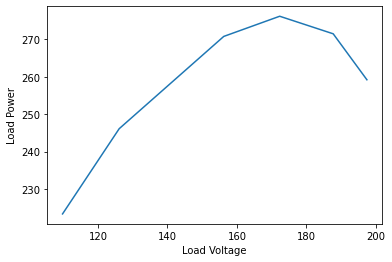

In [25]:
plt.plot(y, x)
plt.ylabel('Load Power')
plt.xlabel('Load Voltage')
plt.show()